In [1]:
!pip install gdown

In [2]:
'''file_id = "1-BSo9bziys0zU_chY5rjvdDXiugQ3VQ1"
output_file = "crema_d/"  # Specify the desired output file name
!gdown https://drive.google.com/uc?id={file_id} -O {output_file}

# Verify the file exists
!ls -l {output_file}
'''

'file_id = "1-BSo9bziys0zU_chY5rjvdDXiugQ3VQ1"\noutput_file = "crema_d/"  # Specify the desired output file name\n!gdown https://drive.google.com/uc?id={file_id} -O {output_file}\n\n# Verify the file exists\n!ls -l {output_file}\n'

In [1]:
%cd crema_d

/scratch/project_2012411/crema_d


In [4]:
#!unzip archive.zip

In [17]:
import os
import pandas as pd
audio_patths = os.listdir('AudioWAV')
train_audio_patths = audio_patths[:int(0.8*len(audio_patths))]
val_audio_patths = audio_patths[int(0.8*len(audio_patths)):int(0.9*len(audio_patths))]
test_audio_patths = audio_patths[int(0.9*len(audio_patths)):]
df = pd.DataFrame(audio_patths,columns=['audio_path'])
df_train = pd.DataFrame(train_audio_patths, columns=['audio_path'])
df_val = pd.DataFrame(val_audio_patths, columns=['audio_path'])
df_test = pd.DataFrame(test_audio_patths, columns=['audio_path'])

def lable_generator(df=df,audio_paths=audio_patths):
  for j,i in enumerate(audio_paths):
    if 'ANG' in i:
      df.loc[j,'Emotions']='Angry'
    elif 'HAP' in i:
      df.loc[j,'Emotions']='Happy'
    elif 'NEU' in i:
     df.loc[j,'Emotions']='Neutral'
    elif 'SAD' in i:
      df.loc[j,'Emotions']='Sad'
    elif 'FEA' in i:
      df.loc[j,'Emotions']='Fearful'
    elif 'DIS' in i:
      df.loc[j,'Emotions']='Disappointed'
   # elif 'SUR' in i:
    #  df.loc[j,'Emotions']='Surprised'
    if 'HI' in i:
      df.loc[j,'Emotional intenisty']='High'
    elif 'LO' in i:
      df.loc[j,'Emotional intenisty']='Low'
    elif 'MD' in i:
      df.loc[j,'Emotional intenisty']='Moderate'
    elif 'XX' in i:
      df.loc[j,'Emotional intenisty']='Unspecified'



In [19]:
len(audio_patths)

7442

In [18]:
lable_generator()
lable_generator(df_train,train_audio_patths)
lable_generator(df_val,val_audio_patths)
lable_generator(df_test,test_audio_patths)

In [8]:
df.head()

,audio_path,Emotions,Emotional intenisty
0,1035_IEO_DIS_MD.wav,Disappointed,Moderate
1,1021_TAI_SAD_XX.wav,Sad,Unspecified
2,1010_TIE_DIS_XX.wav,Disappointed,Unspecified
3,1011_MTI_SAD_XX.wav,Sad,Unspecified
4,1074_IWL_ANG_XX.wav,Angry,Unspecified


In [9]:
df_train.head()

,audio_path,Emotions,Emotional intenisty
0,1035_IEO_DIS_MD.wav,Disappointed,Moderate
1,1021_TAI_SAD_XX.wav,Sad,Unspecified
2,1010_TIE_DIS_XX.wav,Disappointed,Unspecified
3,1011_MTI_SAD_XX.wav,Sad,Unspecified
4,1074_IWL_ANG_XX.wav,Angry,Unspecified


In [10]:
df_val.head()

,audio_path,Emotions,Emotional intenisty
0,1083_ITH_SAD_XX.wav,Sad,Unspecified
1,1056_WSI_FEA_XX.wav,Fearful,Unspecified
2,1068_IWW_DIS_XX.wav,Disappointed,Unspecified
3,1012_IEO_SAD_MD.wav,Sad,Moderate
4,1050_DFA_ANG_XX.wav,Angry,Unspecified


In [11]:
df_test.head()

,audio_path,Emotions,Emotional intenisty
0,1024_TIE_DIS_XX.wav,Disappointed,Unspecified
1,1047_MTI_SAD_XX.wav,Sad,Unspecified
2,1075_TAI_ANG_XX.wav,Angry,Unspecified
3,1074_WSI_ANG_XX.wav,Angry,Unspecified
4,1028_TAI_SAD_XX.wav,Sad,Unspecified


In [12]:
!pip install librosa

In [20]:
import librosa
import numpy as np
import torch

def waveform_to_log_mel_spectrogram(
    audio_path,
    sr=16000,
    n_mels=128,
    win_length_ms=25,
    hop_length_ms=10,
    target_length=1024,
    apply_noise=True,
    apply_time_shift=True,
    apply_speed_perturb=True,
    noise_level=0.005,
    shift_max=0.2,
    speed_factor=1.1
):
 
    waveform, sr = librosa.load(audio_path, sr=sr)
    
    # Data Augmentation
    if apply_noise:
        noise = np.random.normal(0, noise_level, waveform.shape)
        waveform += noise

    if apply_time_shift:
        shift = int(sr * shift_max * np.random.uniform(-1, 1))
        if shift > 0:
            waveform = np.pad(waveform, (shift, 0), mode='constant')[:len(waveform)]
        elif shift < 0:
            waveform = np.pad(waveform, (0, -shift), mode='constant')[:len(waveform)]

    if apply_speed_perturb:
        waveform = librosa.effects.time_stretch(waveform, rate=speed_factor)
    
    # Spectrogram Parameters
    win_length = int(sr * win_length_ms / 1000)
    hop_length = int(sr * hop_length_ms / 1000)
    
    # Compute Mel-spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=waveform,
        sr=sr,
        n_mels=n_mels,
        win_length=win_length,
        hop_length=hop_length,
        window="hamming",
        power=2.0
    )
    
    # Convert to log scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    current_length = log_mel_spectrogram.shape[1]
    
    # Padding or truncation
    if current_length < target_length:
        pad_width = target_length - current_length
        log_mel_spectrogram = np.pad(
            log_mel_spectrogram,
            pad_width=((0, 0), (0, pad_width)),
            mode="constant",
            constant_values=np.min(log_mel_spectrogram)
        )
    else:
        log_mel_spectrogram = log_mel_spectrogram[:, :target_length]
    
    return log_mel_spectrogram

In [21]:
emotion_mapping = {
    'Angry': 0,
    'Happy': 1,
    'Neutral': 2,
    'Sad': 3,
    'Fearful': 4,
    'Disappointed': 5
   # 'Surprised': 6
}
emotional_intensity_mapping = {
    'High':10 ,
    'Low': 11,
    'Moderate': 12,
    'Unspecified': -1
}

In [22]:
df['Emotions mapping'] = df['Emotions'].map(emotion_mapping)
df['Emotional intenisty mapping'] = df['Emotional intenisty'].map(emotional_intensity_mapping)
df_train['Emotions mapping'] = df_train['Emotions'].map(emotion_mapping)
df_train['Emotional intenisty mapping'] = df_train['Emotional intenisty'].map(emotional_intensity_mapping)
df_val['Emotions mapping'] = df_val['Emotions'].map(emotion_mapping)
df_val['Emotional intenisty mapping'] = df_val['Emotional intenisty'].map(emotional_intensity_mapping)
df_test['Emotions mapping'] = df_test['Emotions'].map(emotion_mapping)
df_test['Emotional intenisty mapping'] = df_test['Emotional intenisty'].map(emotional_intensity_mapping)

In [23]:
path = '/scratch/project_2012411/crema_d/AudioWAV/'
df['audio_path'] = df['audio_path'].apply(lambda x: path+x)
df_train['audio_path'] = df_train['audio_path'].apply(lambda x: path+x)
df_val['audio_path'] = df_val['audio_path'].apply(lambda x: path+x)
df_test['audio_path'] = df_test['audio_path'].apply(lambda x: path+x)

In [24]:
df_train["wav spectogram"] = df_train['audio_path'].apply(waveform_to_log_mel_spectrogram)
df_val["wav spectogram"] = df_val['audio_path'].apply(waveform_to_log_mel_spectrogram)
df_test["wav spectogram"] = df_test['audio_path'].apply(waveform_to_log_mel_spectrogram)

In [18]:
df.head()

,audio_path,Emotions,Emotional intenisty,Emotions mapping,Emotional intenisty mapping
0,/scratch/project_2012411/crema_d/AudioWAV/1035...,Disappointed,Moderate,5,12.0
1,/scratch/project_2012411/crema_d/AudioWAV/1021...,Sad,Unspecified,3,-1.0
2,/scratch/project_2012411/crema_d/AudioWAV/1010...,Disappointed,Unspecified,5,-1.0
3,/scratch/project_2012411/crema_d/AudioWAV/1011...,Sad,Unspecified,3,-1.0
4,/scratch/project_2012411/crema_d/AudioWAV/1074...,Angry,Unspecified,0,-1.0


In [19]:
df_train.head()

,audio_path,Emotions,Emotional intenisty,Emotions mapping,Emotional intenisty mapping,wav spectogram
0,/scratch/project_2012411/crema_d/AudioWAV/1035...,Disappointed,Moderate,5,12.0,"[[-80.0, -80.0, -77.51851, -71.23356, -70.7366..."
1,/scratch/project_2012411/crema_d/AudioWAV/1021...,Sad,Unspecified,3,-1.0,"[[-20.50814, -24.544989, -17.78088, -19.866352..."
2,/scratch/project_2012411/crema_d/AudioWAV/1010...,Disappointed,Unspecified,5,-1.0,"[[-27.075806, -18.791056, -17.515598, -14.9064..."
3,/scratch/project_2012411/crema_d/AudioWAV/1011...,Sad,Unspecified,3,-1.0,"[[-80.0, -80.0, -70.36032, -65.62767, -64.1833..."
4,/scratch/project_2012411/crema_d/AudioWAV/1074...,Angry,Unspecified,0,-1.0,"[[-41.744003, -41.494694, -35.901978, -48.1757..."


In [20]:
df_train["wav spectogram"][0]

array([[-80.      , -80.      , -77.51851 , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -77.04295 , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -76.080444, ..., -80.      , -80.      ,
        -80.      ],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

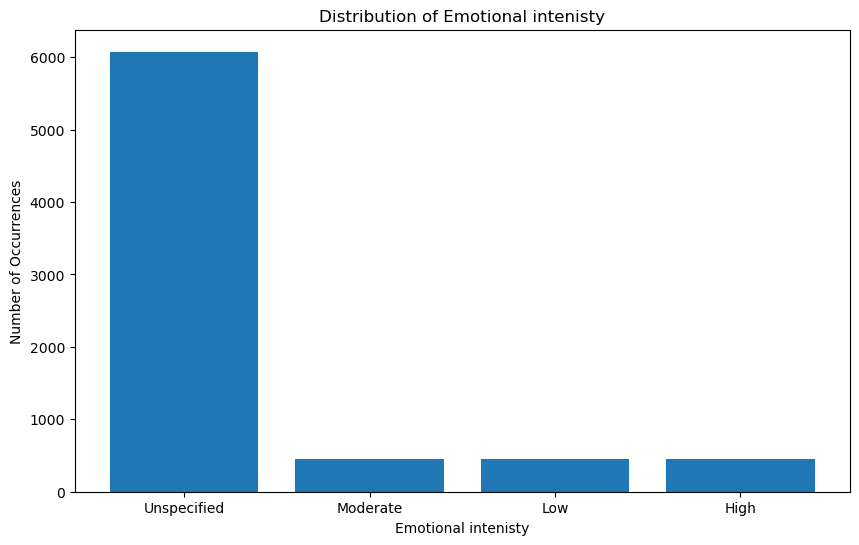

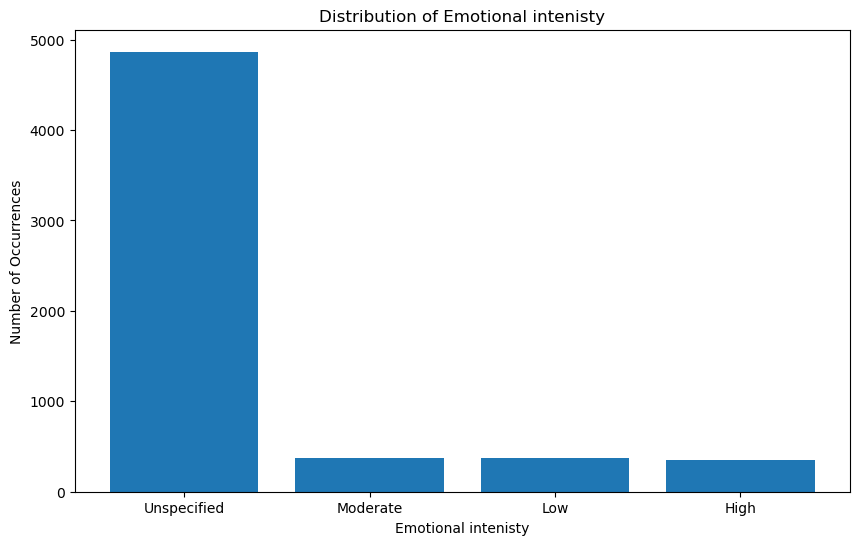

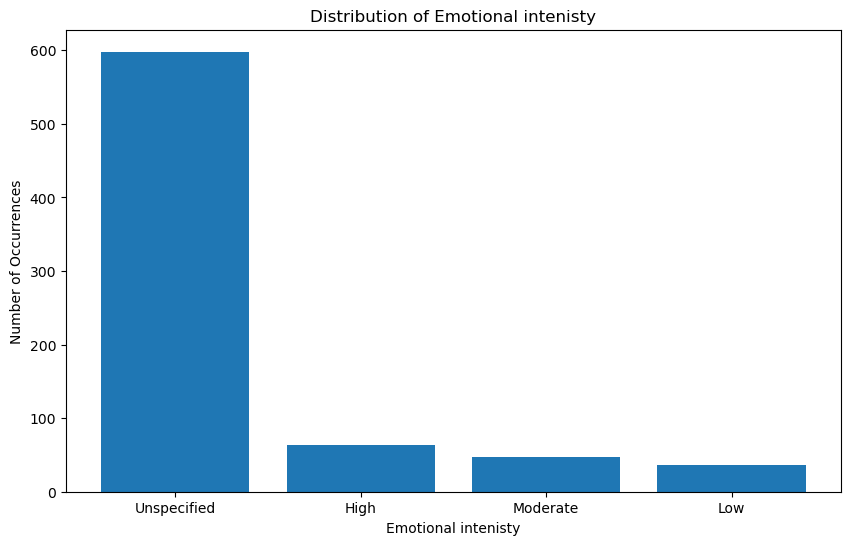

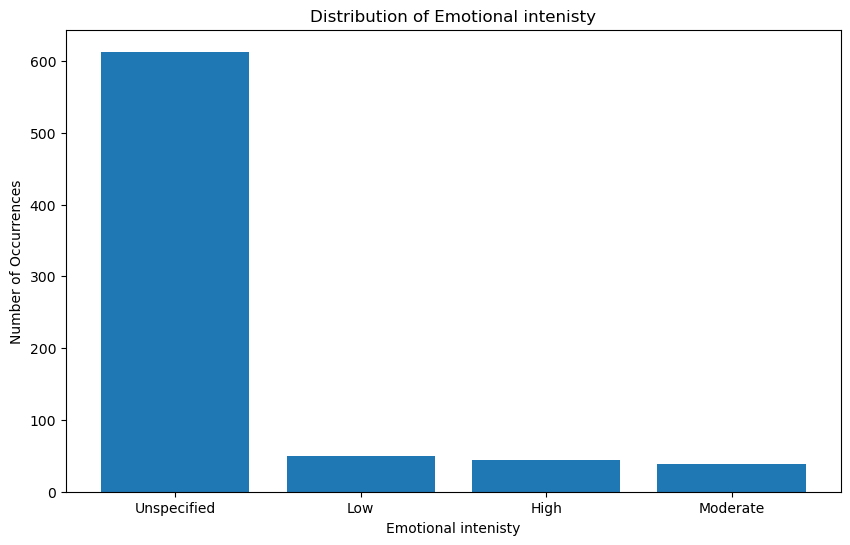

In [21]:
import matplotlib.pyplot as plt
l = [df,df_train,df_val,df_test]
for i in l:
  emotion_counts = i['Emotional intenisty'].value_counts()

  plt.figure(figsize=(10, 6))
  plt.bar(emotion_counts.index, emotion_counts.values)
  plt.xlabel('Emotional intenisty')
  plt.ylabel('Number of Occurrences')
  plt.title('Distribution of Emotional intenisty')
  plt.show()

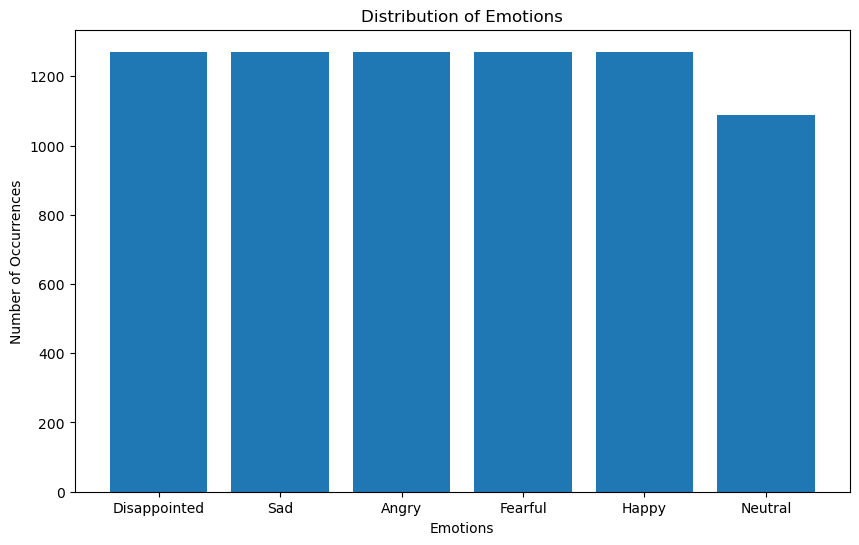

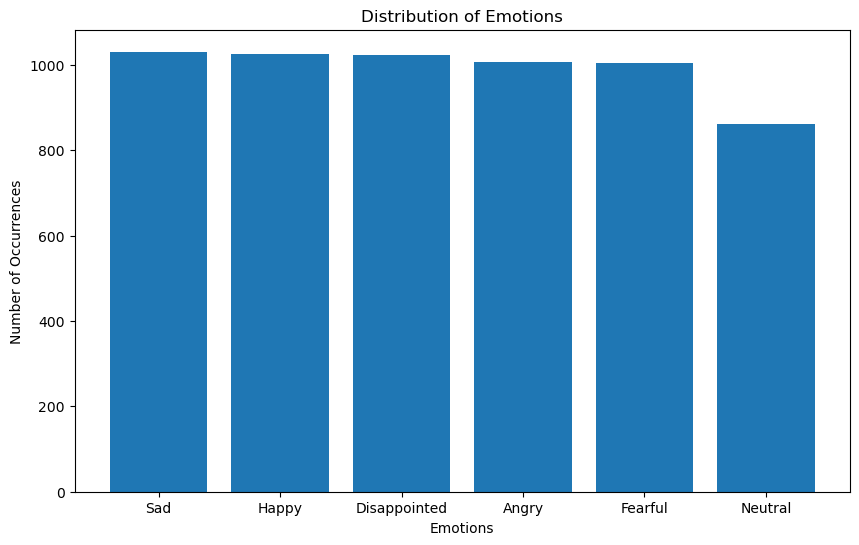

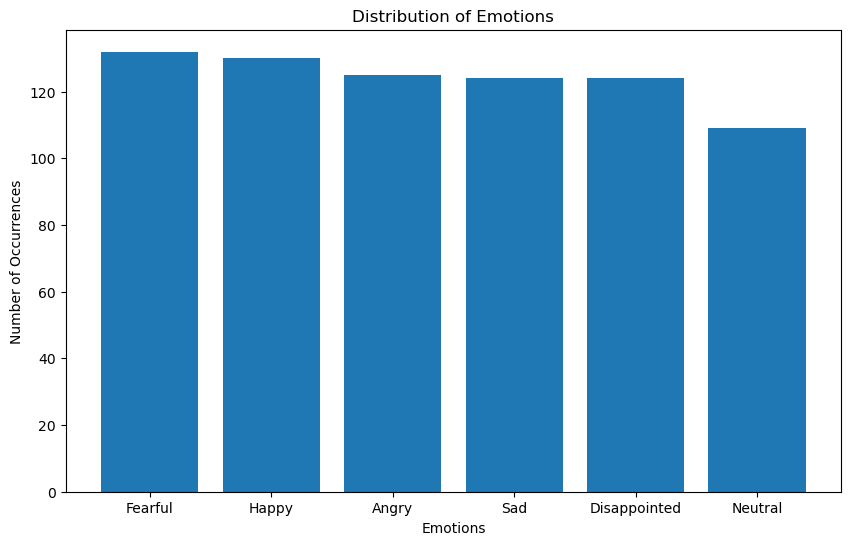

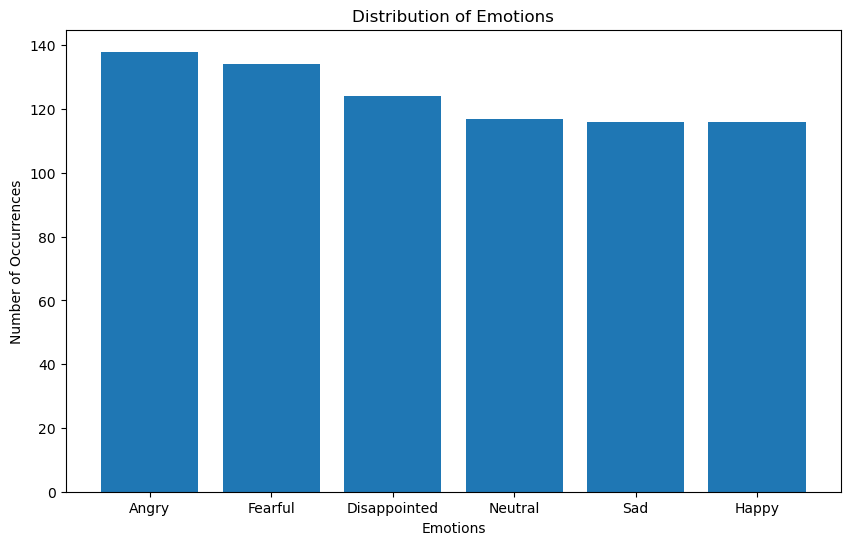

In [22]:
import matplotlib.pyplot as plt
l = [df,df_train,df_val,df_test]
for i in l:
  emotion_counts = i['Emotions'].value_counts()

  plt.figure(figsize=(10, 6))
  plt.bar(emotion_counts.index, emotion_counts.values)
  plt.xlabel('Emotions')
  plt.ylabel('Number of Occurrences')
  plt.title('Distribution of Emotions')
  plt.show()

In [23]:
for i in l:
  emotion_counts = i['Emotional intenisty'].value_counts()

  print(emotion_counts)

  num_elements = len(i['Emotional intenisty'])
  print(f"\nTotal number of elements in 'Emotional intenisty' column: {num_elements}")

Emotional intenisty
Unspecified    6076
Moderate        455
Low             455
High            455
Name: count, dtype: int64

Total number of elements in 'Emotional intenisty' column: 7442
Emotional intenisty
Unspecified    4865
Moderate        370
Low             369
High            348
Name: count, dtype: int64

Total number of elements in 'Emotional intenisty' column: 5953
Emotional intenisty
Unspecified    598
High            63
Moderate        47
Low             36
Name: count, dtype: int64

Total number of elements in 'Emotional intenisty' column: 744
Emotional intenisty
Unspecified    613
Low             50
High            44
Moderate        38
Name: count, dtype: int64

Total number of elements in 'Emotional intenisty' column: 745


In [24]:
for i in l:
  emotion_counts = i['Emotions'].value_counts()

  print(emotion_counts)

  num_elements = len(i['Emotions'])
  print(f"\nTotal number of elements in 'Emotions' column: {num_elements}")

Emotions
Disappointed    1271
Sad             1271
Angry           1271
Fearful         1271
Happy           1271
Neutral         1087
Name: count, dtype: int64

Total number of elements in 'Emotions' column: 7442
Emotions
Sad             1031
Happy           1025
Disappointed    1023
Angry           1008
Fearful         1005
Neutral          861
Name: count, dtype: int64

Total number of elements in 'Emotions' column: 5953
Emotions
Fearful         132
Happy           130
Angry           125
Sad             124
Disappointed    124
Neutral         109
Name: count, dtype: int64

Total number of elements in 'Emotions' column: 744
Emotions
Angry           138
Fearful         134
Disappointed    124
Neutral         117
Sad             116
Happy           116
Name: count, dtype: int64

Total number of elements in 'Emotions' column: 745


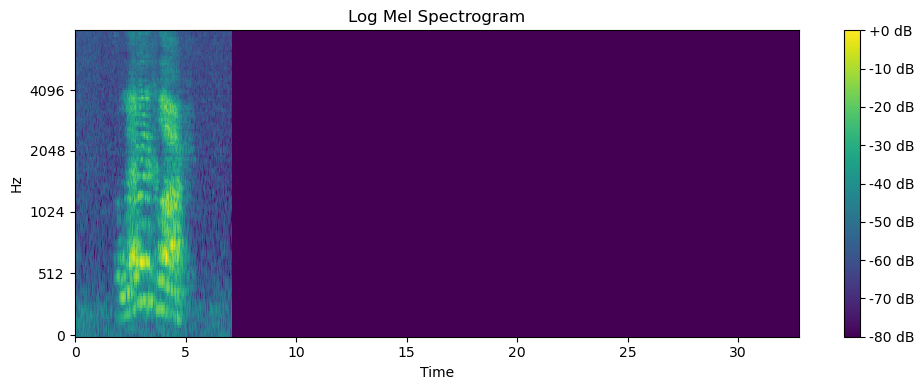

In [25]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


# Example usage
audio_path = df['audio_path'][0]  # Replace with your audio file path
log_mel_spectrogram = waveform_to_log_mel_spectrogram(audio_path)

# Plot the log Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_mel_spectrogram, sr=16000, x_axis='time', y_axis='mel', fmax=8000,cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Log Mel Spectrogram')
plt.tight_layout()
plt.show()

In [14]:
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
class SpectrogramDataset(Dataset):
    def __init__(self, dataframe, normalize=True):
        """
        Initialize the dataset.

        Args:
            dataframe: Pandas DataFrame containing 'wave_spectrogram' and 'Emotions_mapping' columns
            patch_size: Size of patches (default: 16)
            normalize: Whether to normalize the spectrogram patches (default: True)
        """
        self.df = dataframe
        self.np = np.array(self.df["wav spectogram"],dtype=object)
        self.normalize = normalize

    def __len__(self):
        """Return the number of items in the dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Get a single item from the dataset.

        Returns:
            tuple: (patches, label)
                - patches: Tensor of shape (num_patches, patch_size, patch_size)
                - label: Tensor containing the emotion label
        """
        # Get spectrogram and convert to numpy array if it isn't already
        spectrogram = self.np[idx]
        if not isinstance(spectrogram, np.ndarray):
            spectrogram = np.array(spectrogram)

        # Get emotion label
        label = self.df.iloc[idx]['Emotions mapping']
        return torch.tensor(spectrogram), torch.tensor(label, dtype=torch.long)

In [25]:
batch_size = 16
num_workers = 2
train_dataset = SpectrogramDataset(df_train)
val_dataset = SpectrogramDataset(df_val)
test_dataset = SpectrogramDataset(df_test)

In [26]:
train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

In [29]:
import torch
for batch_idx, (spectrograms, labels) in enumerate(train_loader):
    print(f"Spectrograms shape: {spectrograms.shape}, Labels shape: {labels.shape}")
    break

Spectrograms shape: torch.Size([16, 128, 1024]), Labels shape: torch.Size([16])


In [30]:
!pip install tqdm

In [9]:
import torch
import torch.nn as nn
from transformers import ASTModel, ASTConfig
from torch.nn import functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR


class AudioSpectrogramTransformer(nn.Module):
    def __init__(
        self,
        num_classes=6,
        freq_bins=128,
        time_frames=1024,
        pretrained_model_name="MIT/ast-finetuned-audioset-10-10-0.4593",
    ):
        super(AudioSpectrogramTransformer, self).__init__()

        id2label = {v: k for k, v in emotion_mapping.items()}
        label2id = {k: v for k, v in emotion_mapping.items()}

        # Custom AST configuration
        config = ASTConfig(
            hidden_size=768,
            num_attention_heads=12,
            num_hidden_layers=12,
            intermediate_size=3072,
            max_length=1024,
            hidden_dropout_prob=0.3,  # Increased dropout for hidden layers
            attention_probs_dropout_prob=0.3,
            hidden_act="gelu",
            num_mel_bins=128,
            patch_size=16,
            qkv_bias=True,
            layer_norm_eps=1e-12,
            frequency_stride=10,
            time_stride=10,
            problem_type="single_label_classification",
            id2label=id2label,
            label2id=label2id,
        )
        self.ast = ASTModel(config)
        hidden_size = config.hidden_size
        # Output layer for classification
        self.classifier = nn.Linear(config.hidden_size, num_classes)

    def forward(self, spectrograms):
        outputs = self.ast(spectrograms).last_hidden_state
        logits = self.classifier(outputs[:, 0, :])  # Using CLS token output for classification
        return logits

def unfreeze_ast_layers(model, num_layers_to_unfreeze):
 
    for param in model.ast.parameters():
        param.requires_grad = True  # Freeze all AST layers initially

            
def train_one_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # Wrap the train_loader with tqdm for the progress bar
    progress_bar = tqdm(train_loader, desc="Training", leave=True)

    for batch_idx, (spectrograms, labels) in enumerate(progress_bar):
        spectrograms = spectrograms.to(device)  # (batch_size, freq_bins, time_frames)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(spectrograms)
        loss = criterion(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar description
        avg_loss = total_loss / (batch_idx + 1)  # Calculate current average loss
        accuracy = 100 * correct / total if total > 0 else 0
        progress_bar.set_postfix(loss=avg_loss, accuracy=accuracy)

    # Final average loss and accuracy
    avg_loss = total_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
    accuracy = 100 * correct / total if total > 0 else 0

    return avg_loss, accuracy
def linear_decay_schedule(epoch, num_epochs=10):
    return max(1 - epoch / num_epochs, 0)
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for spectrograms, labels in val_loader:
            spectrograms = spectrograms.to(device)  # (batch_size, freq_bins, time_frames)
            labels = labels.to(device)

            logits = model(spectrograms)
            loss = criterion(logits, labels)

            total_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total if total > 0 else 0
    avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else float('inf')

    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, num_epochs=10, device='cuda'):
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW([
        {'params': model.classifier.parameters(), 'lr': 1e-4},
        {'params': filter(lambda p: p.requires_grad, model.ast.parameters()), 'lr': 5e-5}
    ])

    num_training_steps = 1000  # Total training steps
    scheduler = LambdaLR(optimizer, lr_lambda=lambda step: linear_decay_schedule(step, num_training_steps))

    best_val_loss = float('inf')
    best_val_accuracy = 0

    # Start with 1 unfrozen AST layer
    num_layers_to_unfreeze = 1
    total_ast_layers = len(model.ast.encoder.layer)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Gradually unfreeze more layers
        if num_layers_to_unfreeze < total_ast_layers and epoch % 2 == 0:  # Unfreeze every 2 epochs
            num_layers_to_unfreeze += 1
            unfreeze_ast_layers(model, num_layers_to_unfreeze)
            print(f'Unfroze {num_layers_to_unfreeze} AST layers')

        # Ensure optimizer updates only the unfrozen parameters
        optimizer = torch.optim.AdamW([
            {'params': model.classifier.parameters(), 'lr': 1e-4},
            {'params': filter(lambda p: p.requires_grad, model.ast.parameters()), 'lr': 5e-5}
        ])

        # Train and validate
        train_loss, train_accuracy = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy = validate(model, val_loader, criterion, device)

        print(f'Train Loss: {train_loss:.4f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.2f}%')
        scheduler.step()

        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_accuracy': val_accuracy
            }, 'best_model.pth')
            print('Saved best model')

In [10]:

num_classes = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AudioSpectrogramTransformer().to(device)


In [11]:
import torch

model_path = 'best_model.pth'
if os.path.exists(model_path):
    print(f"Loading model from {model_path}")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully!")
else:
    print(f"Model file not found at {model_path}")

Loading model from best_model.pth


/run/nvme/job_25642856/tmp/ipykernel_1288928/1139110235.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


Model loaded successfully!


In [ ]:
train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=15,
        device=device,

    )


Epoch 1/15
Unfroze 2 AST layers


Training: 100%|██████████| 373/373 [08:03<00:00,  1.30s/it, accuracy=58.8, loss=1.07]


Train Loss: 1.0684
Train Accuracy: 58.81%
Val Loss: 1.7273
Val Accuracy: 39.25%


/scratch/project_2012411/AST/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Saved best model

Epoch 2/15


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=60.2, loss=1.03] 


Train Loss: 1.0338
Train Accuracy: 60.17%
Val Loss: 1.6780
Val Accuracy: 43.15%
Saved best model

Epoch 3/15
Unfroze 3 AST layers


Training: 100%|██████████| 373/373 [08:02<00:00,  1.29s/it, accuracy=61.1, loss=1.02] 


Train Loss: 1.0182
Train Accuracy: 61.10%
Val Loss: 1.5995
Val Accuracy: 46.77%
Saved best model

Epoch 4/15


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=61.5, loss=0.993]


Train Loss: 0.9935
Train Accuracy: 61.50%
Val Loss: 1.6643
Val Accuracy: 42.20%

Epoch 5/15
Unfroze 4 AST layers


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=63.1, loss=0.956]


Train Loss: 0.9559
Train Accuracy: 63.08%
Val Loss: 1.8553
Val Accuracy: 42.61%

Epoch 6/15


Training: 100%|██████████| 373/373 [08:01<00:00,  1.29s/it, accuracy=63.9, loss=0.929]


Train Loss: 0.9293
Train Accuracy: 63.88%
Val Loss: 1.8672
Val Accuracy: 41.80%

Epoch 7/15
Unfroze 5 AST layers


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=64.8, loss=0.905]


Train Loss: 0.9054
Train Accuracy: 64.81%
Val Loss: 1.8520
Val Accuracy: 42.34%

Epoch 8/15


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=65.7, loss=0.883]


Train Loss: 0.8826
Train Accuracy: 65.68%
Val Loss: 1.7855
Val Accuracy: 43.01%

Epoch 9/15
Unfroze 6 AST layers


Training: 100%|██████████| 373/373 [08:05<00:00,  1.30s/it, accuracy=67.6, loss=0.842]


Train Loss: 0.8424
Train Accuracy: 67.65%
Val Loss: 2.0168
Val Accuracy: 43.01%

Epoch 10/15


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=68, loss=0.847]  


Train Loss: 0.8469
Train Accuracy: 68.02%
Val Loss: 1.8428
Val Accuracy: 42.74%

Epoch 11/15
Unfroze 7 AST layers


Training: 100%|██████████| 373/373 [07:59<00:00,  1.29s/it, accuracy=69.8, loss=0.787]


Train Loss: 0.7868
Train Accuracy: 69.83%
Val Loss: 2.1792
Val Accuracy: 44.49%

Epoch 12/15


Training:  92%|█████████▏| 344/373 [07:24<00:37,  1.29s/it, accuracy=70.8, loss=0.764]

In [35]:
import torch

# Check for GPU availability
if torch.cuda.is_available():
    # Get the current GPU device
    device = torch.device("cuda")

    # Empty the cache
    torch.cuda.empty_cache()

    # Print a message to confirm
    print("GPU VRAM cache cleared.")
else:
    print("No GPU detected.")

GPU VRAM cache cleared.


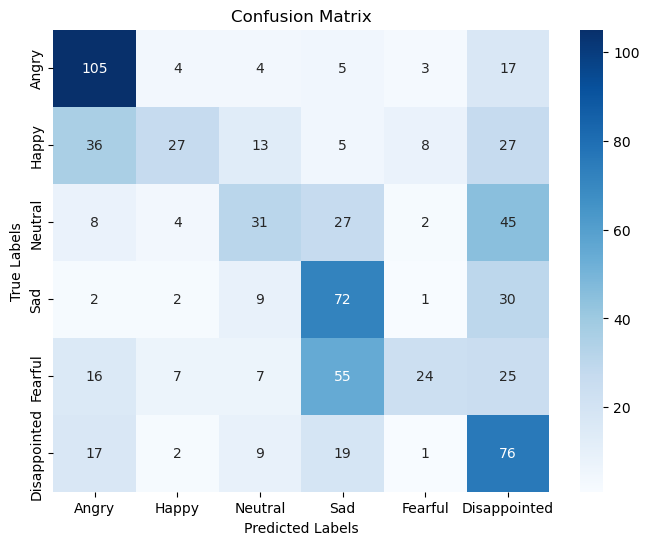

              precision    recall  f1-score   support

       Angry       0.57      0.76      0.65       138
       Happy       0.59      0.23      0.33       116
     Neutral       0.42      0.26      0.33       117
         Sad       0.39      0.62      0.48       116
     Fearful       0.62      0.18      0.28       134
Disappointed       0.35      0.61      0.44       124

    accuracy                           0.45       745
   macro avg       0.49      0.45      0.42       745
weighted avg       0.49      0.45      0.42       745



In [27]:
# prompt: draw confusion matrix and get the classification report

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def test_model_with_metrics(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            logits = model(spectrograms)
            _, predicted = torch.max(logits, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(emotion_mapping.keys()),
                yticklabels=list(emotion_mapping.keys()))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print(classification_report(all_labels, all_predictions, target_names=list(emotion_mapping.keys())))

test_model_with_metrics(model, test_loader, device)